In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from pandas.api.types import CategoricalDtype

%matplotlib inline

In [2]:
survey_data_file = "../data/survey_data.csv"
app_usage_file = "../data/survey_users_app_usage.csv"

In [3]:
df_survey_raw = pd.read_csv(survey_data_file)
# df_app = pd.read_csv(app_usage_file, parse_dates=['duolingo_start_date'])

In [4]:
df_survey_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6187 entries, 0 to 6186
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   user_id                               6187 non-null   object
 1   age                                   5838 non-null   object
 2   annual_income                         5182 non-null   object
 3   country                               6187 non-null   object
 4   duolingo_platform                     5911 non-null   object
 5   duolingo_subscriber                   5901 non-null   object
 6   duolingo_usage                        5911 non-null   object
 7   employment_status                     5730 non-null   object
 8   future_contact                        5446 non-null   object
 9   gender                                5838 non-null   object
 10  other_resources                       4474 non-null   object
 11  primary_language_commitment   

In [5]:
unique_counts = pd.DataFrame.from_records([(col, df_survey_raw[col].nunique()) for col in df_survey_raw.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

In [6]:
unique_counts

,Column_Name,Num_Unique
8,future_contact,2
12,primary_language_review,2
17,survey_complete,2
15,primary_language_proficiency,3
16,student,3
4,duolingo_platform,3
5,duolingo_subscriber,4
7,employment_status,4
9,gender,4
6,duolingo_usage,5


In [7]:
df_survey = df_survey_raw.copy()

In [8]:
#only keep results where survey was completed
total_rows = df_survey.shape[0]
completed_surveys = df_survey['survey_complete'].sum()
print('The data contains {} entries, but only {} where survey_complete is True. Dropping {} rows' \
      .format(total_rows, completed_surveys, total_rows-completed_surveys))

The data contains 6187 entries, but only 5729 where survey_complete is True. Dropping 458 rows


In [9]:
index_names = df_survey[df_survey['survey_complete']==0].index
df_survey.drop(index_names, inplace=True)

In [10]:
# I don't care how long it took people to complete the survey, so dropping that column
# Also, we've already filterd on survey_complete == 1, so dropping that column
# Also don't care if we can contact the user again
df_survey.drop(columns=['time_spent_seconds', 'survey_complete', 'future_contact'], inplace=True)
# 'primary_language_motivation_followup' has high cardinality and lots of NaN's - not useful here
df_survey.drop(columns=['primary_language_motivation_followup'], inplace=True)

In [11]:
# Now let's find duplicate entries by user_id
duplicate_users = df_survey[df_survey.duplicated(['user_id'])]
# duplicate_users.shape[0] -> there are 35 duplicates
# Let's drop the duplicates, and choose to keep the first entry per user
df_survey.drop_duplicates(subset=['user_id'], keep='first', inplace=True)

In [12]:
column_to_check = 'primary_language_proficiency'
print('Unique values in column are: ', [x for x in df_survey[column_to_check].unique()])
print('Total NaNs = {}'.format(df_survey[column_to_check].isnull().sum()))

Unique values in column are:  ['Advanced', 'Intermediate', 'Beginner', nan]
Total NaNs = 4


In [13]:
# Now let's see if we can fill some missing values
df_survey['duolingo_platform'].fillna('Unknown', inplace=True)
df_survey['duolingo_subscriber'].fillna("I don't know if I pay for Duolingo Plus", inplace=True)
df_survey['duolingo_usage'].fillna("I don't use Duolingo", inplace=True)
# with 110 nan's, leaving 'employment_status' NaN for now - to be imputed later
# 'age' has 9 Nan's, but is highly correlated with 'employment_status' and 'student' so will try to impute
# 'annual_income' has 633 NaN's - will try to impute later
df_survey['gender'].fillna("Prefer not to say", inplace=True) # they didn't answer the question, and only 10 NaN's
# 'primary_language_commitment' has only 6 NaN's - leaving those for now
# 'primary_language_review' has only 13 NaN's - leaving those for now
# 'primary_language_motivation' has only 15 NaN's - leaving those for now
# 'primary_language_proficiency' has only 4 NaN's - leaving those for now
# 'student' has 307 NaN's - will try to impute

In [14]:
# Next, let's encode some categorical variables where ordering doesn't matter
df_survey['country'] = df_survey['country'].astype('category')
df_survey['duolingo_platform'] = df_survey['duolingo_platform'].astype('category')
df_survey['duolingo_subscriber'] = df_survey['duolingo_subscriber'].astype('category')
df_survey['employment_status'] = df_survey['employment_status'].astype('category')
df_survey['gender'] = df_survey['gender'].astype('category')
df_survey['student'] = df_survey['student'].astype('category')
df_survey['primary_language_review'] = df_survey['primary_language_review'].astype('category')
df_survey['primary_language_motivation'] = df_survey['primary_language_motivation'].astype('category')

In [15]:
# Next, mapping ordinal categories where ordering does matter
# 'duolingo_usage'
usage_ordering = ["I don't use Duolingo", "Less than once a month", "Monthly", "Weekly", "Daily"]
usage_type = CategoricalDtype(categories=usage_ordering, ordered=True)
df_survey['duolingo_usage'] = df_survey['duolingo_usage'].astype('category')
df_survey['duolingo_usage'] = df_survey['duolingo_usage'].cat.reorder_categories(usage_ordering, ordered=True)

# 'age'
age_ordering = ['Under 18', '18-34', '35 - 54', '55 - 74', '75 or older']
age_type = CategoricalDtype(categories=age_ordering, ordered=True)
df_survey['age'] = df_survey['age'].astype('category')
df_survey['age'] = df_survey['age'].cat.reorder_categories(age_ordering, ordered=True)

# 'annual_income'
income_ordering = ['$0 - $10,000', '$11,000 - $25,000', '$26,000 - $75,000', '$76,000 - $150,000', '$151,000 or more']
income_type = CategoricalDtype(categories=income_ordering, ordered=True)
df_survey['annual_income'] = df_survey['annual_income'].astype('category')
df_survey['annual_income'] = df_survey['annual_income'].cat.reorder_categories(income_ordering, ordered=True)

# 'primary_language_commitment'
commitment_ordering = ["I'm not at all committed to learning this language.",
                       "I'm slightly committed to learning this language.", 
                       "I'm moderately committed to learning this language.", 
                       "I'm very committed to learning this language.", 
                       "I'm extremely committed to learning this language."]
commitment_type = CategoricalDtype(categories=commitment_ordering, ordered=True)
df_survey['primary_language_commitment'] = df_survey['primary_language_commitment'].astype('category')
df_survey['primary_language_commitment'] = df_survey['primary_language_commitment'].cat.reorder_categories(commitment_ordering, ordered=True)

# 'primary_language_proficiency'
proficiency_ordering = ['Beginner', 'Intermediate', 'Advanced']
proficiency_type = CategoricalDtype(categories=proficiency_ordering, ordered=True)
df_survey['primary_language_proficiency'] = df_survey['primary_language_proficiency'].astype('category')
df_survey['primary_language_proficiency'] = df_survey['primary_language_proficiency'].cat.reorder_categories(proficiency_ordering, ordered=True)


In [16]:
df_survey['used_other_resources'] = np.where(len(df_survey['other_resources'])>1, True, False)

In [17]:
df_survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5694 entries, 0 to 6186
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   user_id                       5694 non-null   object  
 1   age                           5685 non-null   category
 2   annual_income                 5061 non-null   category
 3   country                       5694 non-null   category
 4   duolingo_platform             5694 non-null   category
 5   duolingo_subscriber           5694 non-null   category
 6   duolingo_usage                5694 non-null   category
 7   employment_status             5584 non-null   category
 8   gender                        5694 non-null   category
 9   other_resources               4289 non-null   object  
 10  primary_language_commitment   5688 non-null   category
 11  primary_language_review       5681 non-null   category
 12  primary_language_motivation   5679 non-null   ca

In [18]:
df_app_raw = pd.read_csv(app_usage_file, parse_dates=['duolingo_start_date'])

In [19]:
df_app_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6149 entries, 0 to 6148
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  6149 non-null   object        
 1   duolingo_start_date      6149 non-null   datetime64[ns]
 2   daily_goal               2687 non-null   float64       
 3   highest_course_progress  6135 non-null   float64       
 4   took_placement_test      6135 non-null   object        
 5   purchased_subscription   6149 non-null   bool          
 6   highest_crown_count      5857 non-null   float64       
 7   n_active_days            6149 non-null   int64         
 8   n_lessons_started        5993 non-null   float64       
 9   n_lessons_completed      5993 non-null   float64       
 10  longest_streak           6149 non-null   int64         
 11  n_days_on_platform       6149 non-null   int64         
dtypes: bool(1), datetime64[ns](1), flo

In [20]:
df_app = df_app_raw.copy()

In [21]:
column_to_check = 'took_placement_test'
print('Unique values in column are: ', [x for x in df_app[column_to_check].unique()])
print('Total NaNs = {}'.format(df_app[column_to_check].isnull().sum()))

Unique values in column are:  [True, False, nan]
Total NaNs = 14


In [22]:
#Fill NaN's and change column types as needed
df_app['took_placement_test'].fillna('False', inplace=True)
df_app['took_placement_test'] = df_app['took_placement_test'].astype('bool')

In [23]:
start_date = np.datetime64('2018-08-01')
end_date = np.datetime64('2018-11-05')
print(end_date - start_date) 
#anything longer, the data must be wrong

96 days


In [24]:
# calculated columns
df_app['has_daily_goal'] = np.where(df_app['daily_goal'] > 0, True, False)
df_app['n_active_days'] = np.where(df_app['n_active_days'] > 97, 97, df_app['n_active_days'])
df_app['pct_days_active'] = df_app['n_active_days']/97
df_app['lessons_per_day'] = df_app['n_lessons_started']/df_app['n_active_days']
df_app['log_lessons_per_day'] = np.log(df_app['lessons_per_day'])

In [25]:
duplicate_users = df_app[df_app.duplicated(['user_id'])]
df_app.drop_duplicates(subset=['user_id'], keep='first', inplace=True)

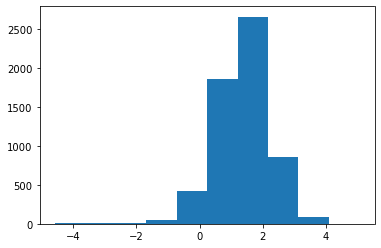

In [26]:
plt.hist(df_app['log_lessons_per_day'])
plt.show()

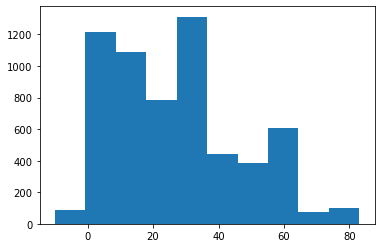

In [27]:
plt.hist(df_app['highest_course_progress'])
plt.show()

In [28]:
df_app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6114 entries, 0 to 6148
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  6114 non-null   object        
 1   duolingo_start_date      6114 non-null   datetime64[ns]
 2   daily_goal               2670 non-null   float64       
 3   highest_course_progress  6100 non-null   float64       
 4   took_placement_test      6114 non-null   bool          
 5   purchased_subscription   6114 non-null   bool          
 6   highest_crown_count      5822 non-null   float64       
 7   n_active_days            6114 non-null   int64         
 8   n_lessons_started        5958 non-null   float64       
 9   n_lessons_completed      5958 non-null   float64       
 10  longest_streak           6114 non-null   int64         
 11  n_days_on_platform       6114 non-null   int64         
 12  has_daily_goal           6114 non-

In [29]:
df = df_survey.join(df_app.set_index('user_id'), on='user_id')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5694 entries, 0 to 6186
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   user_id                       5694 non-null   object        
 1   age                           5685 non-null   category      
 2   annual_income                 5061 non-null   category      
 3   country                       5694 non-null   category      
 4   duolingo_platform             5694 non-null   category      
 5   duolingo_subscriber           5694 non-null   category      
 6   duolingo_usage                5694 non-null   category      
 7   employment_status             5584 non-null   category      
 8   gender                        5694 non-null   category      
 9   other_resources               4289 non-null   object        
 10  primary_language_commitment   5688 non-null   category      
 11  primary_language_review       

In [31]:
df['took_placement_test'] = df['took_placement_test'].astype('bool')
df['purchased_subscription'] = df['purchased_subscription'].astype('bool')
df['has_daily_goal'] = df['has_daily_goal'].astype('bool')

In [32]:
df.drop(columns=['daily_goal', 'other_resources', 'n_lessons_completed',
                 'highest_crown_count', 'n_active_days', 'n_lessons_started', 'longest_streak',
                'lessons_per_day', 'duolingo_start_date'], inplace=True)

In [33]:
df.dropna(inplace=True)

In [34]:
df.isnull().sum()

user_id                         0
age                             0
annual_income                   0
country                         0
duolingo_platform               0
duolingo_subscriber             0
duolingo_usage                  0
employment_status               0
gender                          0
primary_language_commitment     0
primary_language_review         0
primary_language_motivation     0
primary_language_proficiency    0
student                         0
used_other_resources            0
highest_course_progress         0
took_placement_test             0
purchased_subscription          0
n_days_on_platform              0
has_daily_goal                  0
pct_days_active                 0
log_lessons_per_day             0
dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4614 entries, 0 to 6185
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   user_id                       4614 non-null   object  
 1   age                           4614 non-null   category
 2   annual_income                 4614 non-null   category
 3   country                       4614 non-null   category
 4   duolingo_platform             4614 non-null   category
 5   duolingo_subscriber           4614 non-null   category
 6   duolingo_usage                4614 non-null   category
 7   employment_status             4614 non-null   category
 8   gender                        4614 non-null   category
 9   primary_language_commitment   4614 non-null   category
 10  primary_language_review       4614 non-null   category
 11  primary_language_motivation   4614 non-null   category
 12  primary_language_proficiency  4614 non-null   ca

In [36]:
#storing it to be used in the next notebook
%store df

Stored 'df' (DataFrame)
